# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 13

**Author 1 (sciper):** Nicolas Kieffer (270647)   
**Author 2 (sciper):** Grégoire Bergamo (274547)  
**Author 3 (sciper):** Maxime Poffet (273555)  

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

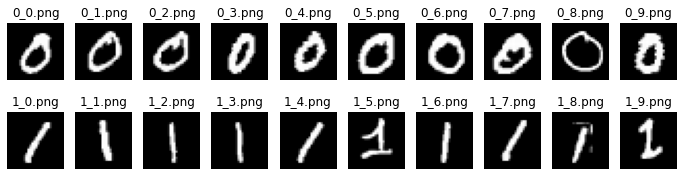

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

### Description

In order to perform the Fourier descriptors method, we first have to find the contour of the object. We used the Open CV function findContour to do so. This function is very useful because not only does it find the contour of the object, but it also sorts the points of the contour by neighboring points, in the direction of the contour. Then, to always have the same number of points in the contour, we resample them in our resampling_cnt function. Afterwards, we have to pass the coordinates of the points of the contour into complex form, and then compute the Discrete Fourier Transform (DFT) of them. This gives us the descriptors that we want.

As the translation only affect f0, we chose not to use it. The phase is affected by the rotation of the image, we then take the norm of the complex numbers a1, a2 and a3. Finaly, as a scaling multiply all descriptors, the ratio of two of them is not affected by a change in scale. The two descriptors chosen are a2/a1 and a3/a1, they are theoretically invariant to rotation, translation and scaling.

Once we have the descriptors we can plot the different values that we have depending on the numbers written in the original pictures. We can then observe the intra and inter-class distance between the points. We had to reduce the initial performance of our algorithm in order to respect the invariant criteria, which is more important to be able to analyze a lot of different images. We checked the invariant criteria by changing the images with first of all a rotation, then a translation, and finally with scaling. The small variation in the descriptors are due to the errors of interpolation and the low quality of the images.

In [3]:
from skimage.morphology import erosion, disk
from skimage.segmentation import mark_boundaries, clear_border
from skimage.measure import label, regionprops
import numpy as np
import cv2 as cv
from scipy.interpolate import splprep, splev
import itertools

In [4]:
def resampling_cnt(cnt):
    x,y = cnt.T
    x = x.tolist()[0]
    y = y.tolist()[0]

    tck, u = splprep([x,y],k=5, s=0)
    
    u_sampled = np.linspace(u.min(), u.max(), 100)
    
    x_sampled, y_sampled = splev(u_sampled, tck, der=0)

    sampled_points = [[[int(i[0]), int(i[1])]] for i in zip(x_sampled,y_sampled)]
    
    return np.asarray(sampled_points, dtype=np.int32)

In [5]:
def compute_descriptors(img):
    
    descriptors_select =[]
    for im in range(0, len(img)):
        im_binary = cv.inRange(img[im], (190), (255))

        contours = cv.findContours(im_binary, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)[-2]
        
        contours_big = []
        for cnt in contours:
            if np.size(cnt)>10:
                contours_big.append(cnt)
                              
        full_cnt = np.vstack(contours_big)

        sampled_cnt = resampling_cnt(full_cnt)
           
        contour_complex = [complex(sampled_cnt[i][0][0], sampled_cnt[i][0][1]) for i in range(0, len(sampled_cnt))]
        descriptors = np.fft.fft(contour_complex)
        #don't use a0 so that it is translation invariant
        #norm so that it is rotation invariant
        #ratio so that it is scaling invariant
        a1 = np.sqrt((descriptors[1].real)**2 + (descriptors[1].imag)**2)
        a2 = np.sqrt((descriptors[2].real)**2 + (descriptors[2].imag)**2)
        a3 = np.sqrt((descriptors[3].real)**2 + (descriptors[3].imag)**2)
        descriptors_select.append((a2/a1, a3/a1))

    
    return descriptors_select

In [6]:
def plot_descriptors(descriptors_zeros, descriptors_ones, title, x_label, y_label):
    
    a1_zeros = [a[0] for a in descriptors_zeros]
    a2_zeros = [a[1] for a in descriptors_zeros]
    a1_ones = [a[0] for a in descriptors_ones]
    a2_ones = [a[1] for a in descriptors_ones]
    plt.scatter(a1_zeros, a2_zeros, color='r', label='zeros')
    plt.scatter(a1_ones, a2_ones, color='b', label='ones')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

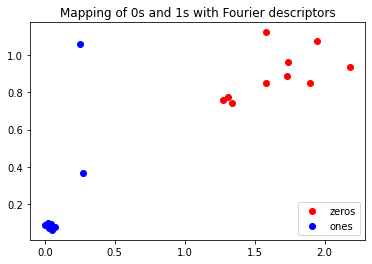

In [7]:
descriptors_zeros = compute_descriptors(zeros_im)
descriptors_ones = compute_descriptors(ones_im)
plot_descriptors(descriptors_zeros, descriptors_ones, 'Mapping of 0s and 1s with Fourier descriptors', 'a2/a1', 'a3/a1')

In [8]:
def plot_transformed_images(original_img, trans_img1, trans_img2, trans_img3, names):
    
    fig, axes = plt.subplots(4, len(zeros_im), figsize=(30, 10))
    
    for ax, im, nm in zip(axes[0], original_img, names):
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        ax.set_title('Original ' + nm)
    
    for ax, im, nm in zip(axes[1], trans_img1, names):
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        ax.set_title('90° rotated ' + nm)
    
    for ax, im in zip(axes[2], trans_img2):
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        ax.set_title('180° rotated ' + nm)
    
    for ax, im in zip(axes[3], trans_img3):
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        ax.set_title('270° rotated ' + nm)
        
    plt.title('Test')
    plt.show()

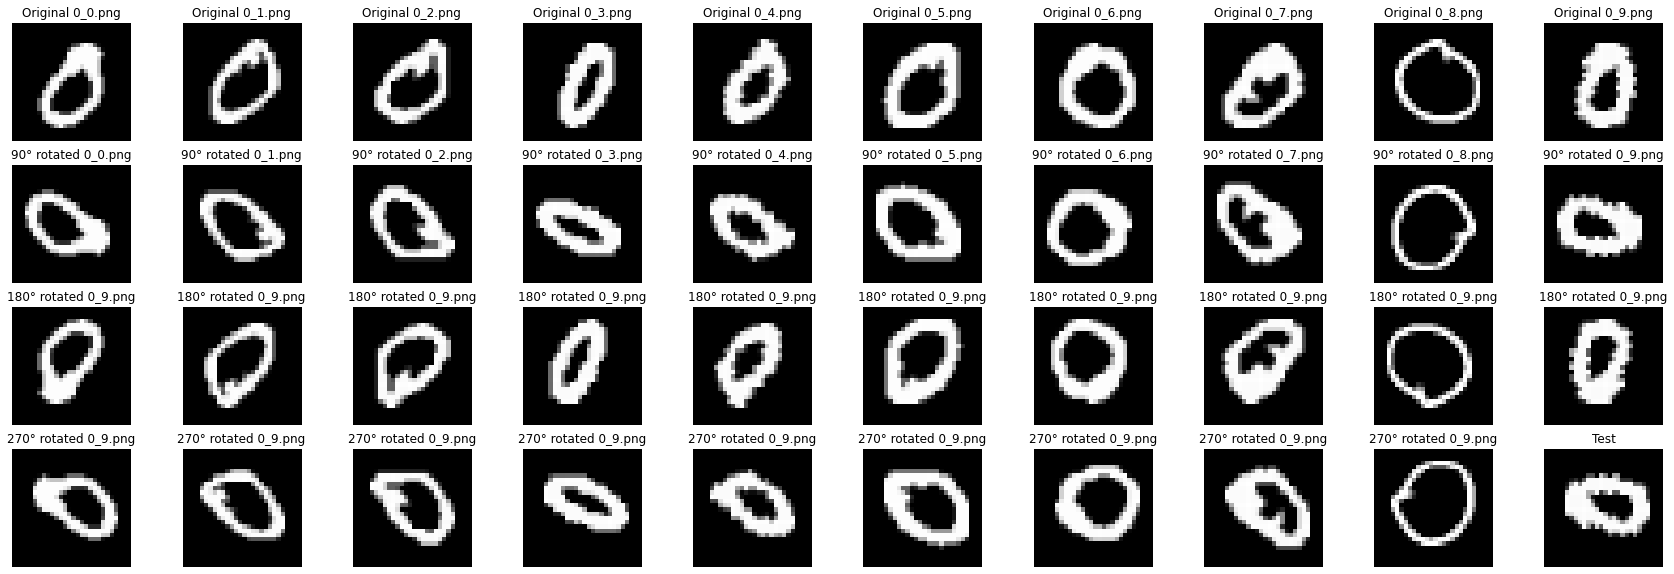

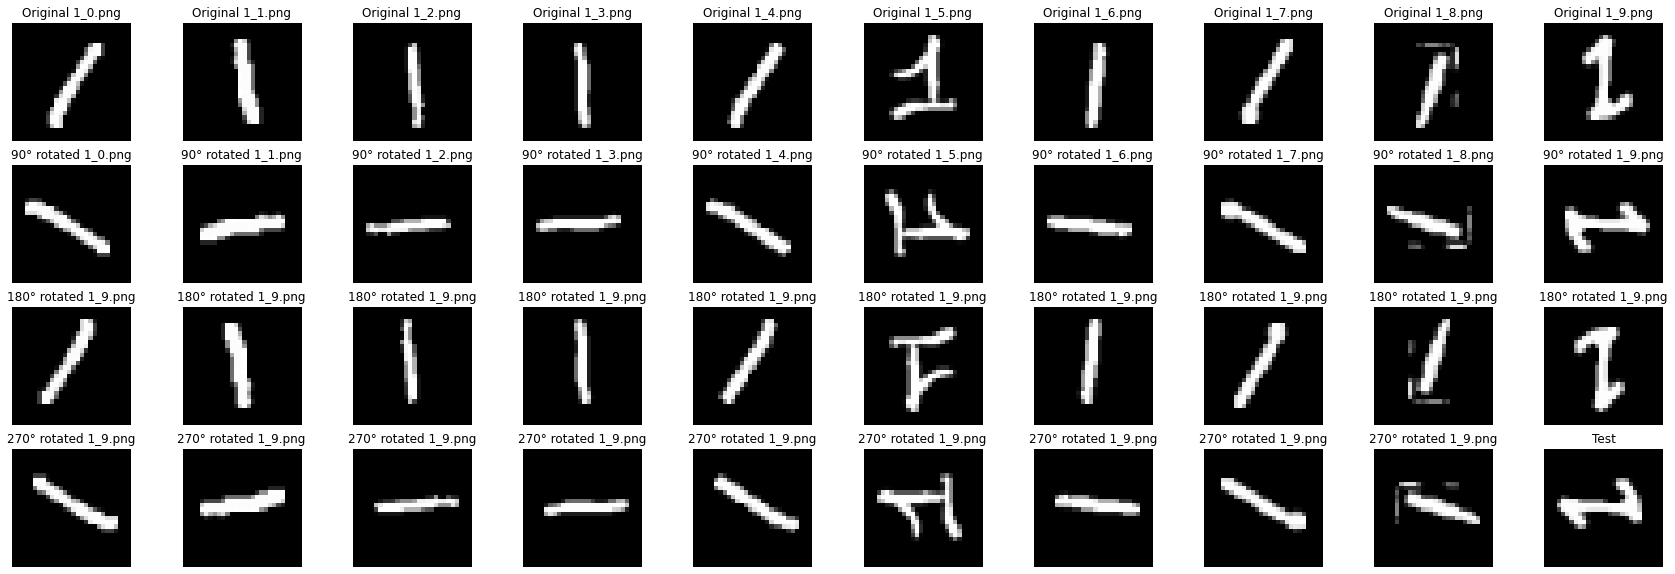

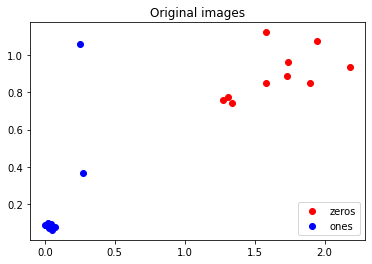

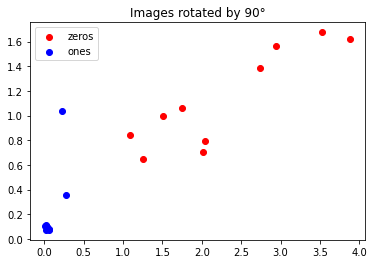

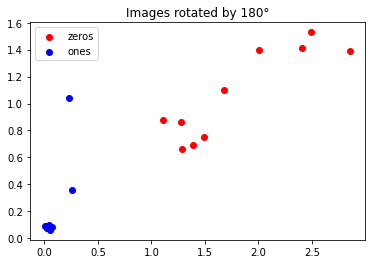

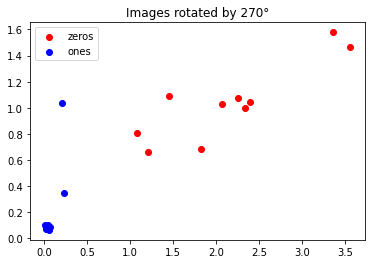

In [9]:
#ROTATION

zeros_im_90 = np.zeros(zeros_im.shape)
zeros_im_180 = np.zeros(zeros_im.shape)
zeros_im_270 = np.zeros(zeros_im.shape)

for im in range(0, len(zeros_im)):
    zeros_im_90[im] = cv.rotate(zeros_im[im], cv.ROTATE_90_CLOCKWISE)
    zeros_im_180[im] = cv.rotate(zeros_im[im], cv.ROTATE_180)
    zeros_im_270[im] = cv.rotate(zeros_im[im], cv.ROTATE_90_COUNTERCLOCKWISE)
    
plot_transformed_images(zeros_im, zeros_im_90, zeros_im_180, zeros_im_270, zeros_names)
    
ones_im_90 = np.zeros(ones_im.shape)
ones_im_180 = np.zeros(ones_im.shape)
ones_im_270 = np.zeros(ones_im.shape)

for im in range(0, len(ones_im)):
    ones_im_90[im] = cv.rotate(ones_im[im], cv.ROTATE_90_CLOCKWISE)
    ones_im_180[im] = cv.rotate(ones_im[im], cv.ROTATE_180)
    ones_im_270[im] = cv.rotate(ones_im[im], cv.ROTATE_90_COUNTERCLOCKWISE)
    
plot_transformed_images(ones_im, ones_im_90, ones_im_180, ones_im_270, ones_names)

descriptors_zeros_90 = compute_descriptors(zeros_im_90)
descriptors_zeros_180 = compute_descriptors(zeros_im_180)
descriptors_zeros_270 = compute_descriptors(zeros_im_270)

descriptors_ones_90 = compute_descriptors(ones_im_90)
descriptors_ones_180 = compute_descriptors(ones_im_180)
descriptors_ones_270 = compute_descriptors(ones_im_270)

plot_descriptors(descriptors_zeros, descriptors_ones, 'Original images', 'a2/a1', 'a3/a1')
plot_descriptors(descriptors_zeros_90, descriptors_ones_90, 'Images rotated by 90°', 'a2/a1', 'a3/a1')
plot_descriptors(descriptors_zeros_180, descriptors_ones_180, 'Images rotated by 180°', 'a2/a1', 'a3/a1')
plot_descriptors(descriptors_zeros_270, descriptors_ones_270, 'Images rotated by 270°', 'a2/a1', 'a3/a1')


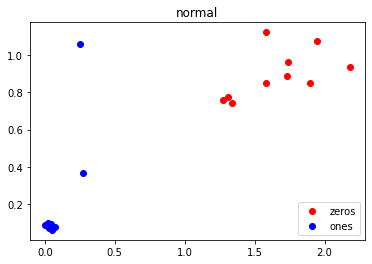

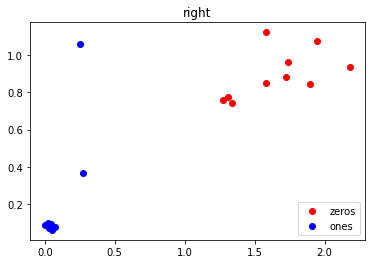

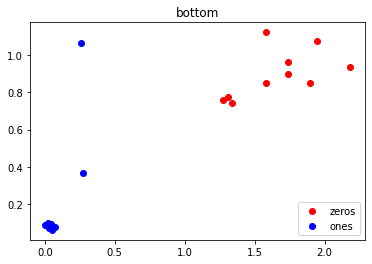

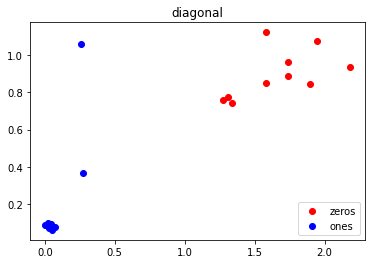

In [10]:
#TRANSLATION

M_right = np.float32([[1, 0, 2],[0, 1, 0]])
M_bot = np.float32([[1, 0, 0],[0, 1, 2]])
M_dia = np.float32([[1, 0, 2],[0, 1, 2]])

zeros_im_right = np.zeros(zeros_im.shape)
zeros_im_bot = np.zeros((zeros_im.shape))
zeros_im_dia = np.zeros((zeros_im.shape))
for im in range(0, len(zeros_im)):
    zeros_im_right[im] = cv.warpAffine(zeros_im[im], M_right, (zeros_im[im].shape[1], zeros_im[im].shape[0]))
    zeros_im_bot[im] = cv.warpAffine(zeros_im[im], M_bot, (zeros_im[im].shape[1], zeros_im[im].shape[0]))
    zeros_im_dia[im] = cv.warpAffine(zeros_im[im], M_dia, (zeros_im[im].shape[1], zeros_im[im].shape[0]))
    
ones_im_right = np.zeros(ones_im.shape)
ones_im_bot = np.zeros((ones_im.shape))
ones_im_dia = np.zeros((ones_im.shape))
for im in range(0, len(ones_im)):
    ones_im_right[im] = cv.warpAffine(ones_im[im], M_right, (ones_im[im].shape[1], ones_im[im].shape[0]))
    ones_im_bot[im] = cv.warpAffine(ones_im[im], M_bot, (ones_im[im].shape[1], ones_im[im].shape[0]))
    ones_im_dia[im] = cv.warpAffine(ones_im[im], M_dia, (ones_im[im].shape[1], ones_im[im].shape[0]))

descriptors_zeros_right = compute_descriptors(zeros_im_right)
descriptors_zeros_bot = compute_descriptors(zeros_im_bot)
descriptors_zeros_dia = compute_descriptors(zeros_im_dia)

descriptors_ones_right = compute_descriptors(ones_im_right)
descriptors_ones_bot = compute_descriptors(ones_im_bot)
descriptors_ones_dia = compute_descriptors(ones_im_dia)


plot_descriptors(descriptors_zeros, descriptors_ones, 'normal', 'a2/a1', 'a3/a1')
plot_descriptors(descriptors_zeros_right, descriptors_ones_right, 'right', 'a2/a1', 'a3/a1')
plot_descriptors(descriptors_zeros_bot, descriptors_ones_bot, 'bottom', 'a2/a1', 'a3/a1')
plot_descriptors(descriptors_zeros_dia, descriptors_ones_dia, 'diagonal', 'a2/a1', 'a3/a1')



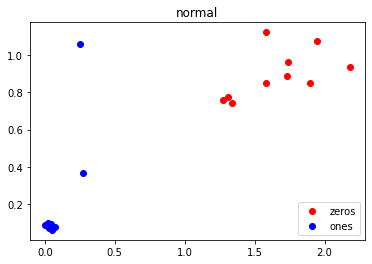

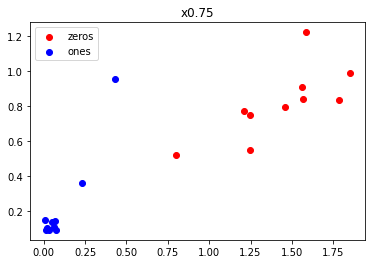

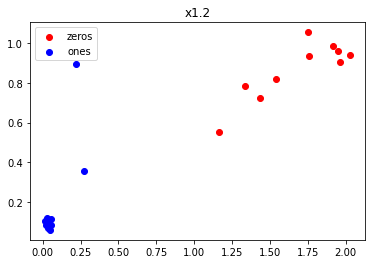

In [11]:
#SCALING
zeros_im_075_prov = np.zeros((10,21,21))
zeros_im_075 = np.zeros((10,28,28))
zeros_im_12_prov = np.zeros((10,34,34))
zeros_im_12 = np.zeros((10,28,28))
for im in range(0, len(zeros_im)):
    zeros_im_075_prov[im] = cv.resize(zeros_im[im], (0,0), fx=0.75, fy=0.75)
    zeros_im_075[im][3:24, 3:24] = zeros_im_075_prov[im]
    zeros_im_12_prov[im] = cv.resize(zeros_im[im], (0,0), fx=1.2, fy=1.2)
    zeros_im_12[im] = zeros_im_12_prov[im][3:31, 3:31]


ones_im_075_prov = np.zeros((10,21,21))
ones_im_075 = np.zeros((10,28,28))
ones_im_12_prov = np.zeros((10,34,34))
ones_im_12 = np.zeros((10,28,28))
for im in range(0, len(ones_im)):
    ones_im_075_prov[im] = cv.resize(ones_im[im], (0,0), fx=0.75, fy=0.75)
    ones_im_075[im][3:24, 3:24] = ones_im_075_prov[im]
    ones_im_12_prov[im] = cv.resize(ones_im[im], (0,0), fx=1.2, fy=1.2)
    ones_im_12[im] = ones_im_12_prov[im][3:31, 3:31]

descriptors_zeros_075 = compute_descriptors(zeros_im_075)
descriptors_zeros_12 = compute_descriptors(zeros_im_12)

descriptors_ones_075 = compute_descriptors(ones_im_075)
descriptors_ones_12 = compute_descriptors(ones_im_12)


plot_descriptors(descriptors_zeros, descriptors_ones, 'normal', 'a2/a1', 'a3/a1')
plot_descriptors(descriptors_zeros_075, descriptors_ones_075, 'x0.75', 'a2/a1', 'a3/a1')
plot_descriptors(descriptors_zeros_12, descriptors_ones_12, 'x1.2', 'a2/a1', 'a3/a1')

### 1.3 Additional method (5 pts)


### Description

For the additional method we tried to choose descriptors that would differentiate the most the zeros and ones. We started again by taking the contour of the numbers. As the zeros are round, the compacity of their contour is rather small, in contrary to the ones. Furthermore, the moment of the zeros is way bigger than for the ones. We then chose those two caracteristics as descriptors. For the test images, the classes are well separated. However, those descriptors are not invariant to scaling.

In [12]:
def compute_ad_descriptors(img):
    descriptors_ad =[]
    for im in range(0, len(img)):
        im_binary = cv.inRange(img[im], (1), (255))

        contours = cv.findContours(im_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)[-2]
        max_area_cnt = max(contours, key=cv.contourArea)

        area = cv.contourArea(max_area_cnt)
        perimeter = cv.arcLength(max_area_cnt,True)
        compacity = (perimeter**2)/area

        moment = cv.moments(max_area_cnt)

        descriptors_ad.append((compacity, moment['m00']))
    
    return descriptors_ad

In [13]:
ad_descriptors_zeros = compute_ad_descriptors(zeros_im)
ad_descriptors_ones = compute_ad_descriptors(ones_im)

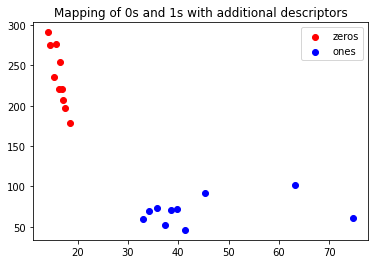

In [19]:
plot_descriptors(ad_descriptors_zeros, ad_descriptors_ones, 'Mapping of 0s and 1s with additional descriptors', 'Compacity', 'Moment')

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

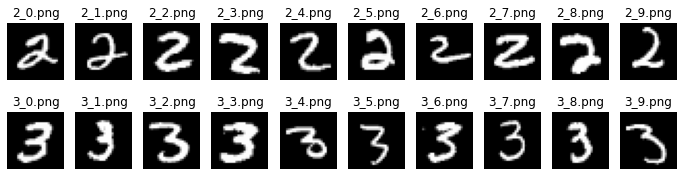

In [15]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

### Description

For this part, we used the same functions as in the first part. We can observe the limits of our method in the final plot, where we can see that the intra and inter-distance for the twos and threes is not satisfactory. 

In [16]:
descriptors_twos = compute_descriptors(twos_im)    
descriptors_threes = compute_descriptors(threes_im)   

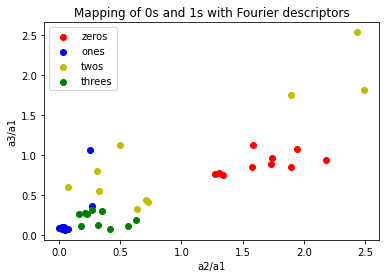

In [23]:
a1_zeros = [a[0] for a in descriptors_zeros]
a2_zeros = [a[1] for a in descriptors_zeros]
a1_ones = [a[0] for a in descriptors_ones]
a2_ones = [a[1] for a in descriptors_ones]
a1_twos = [a[0] for a in descriptors_twos]
a2_twos = [a[1] for a in descriptors_twos]
a1_threes = [a[0] for a in descriptors_threes]
a2_threes = [a[1] for a in descriptors_threes]
plt.scatter(a1_zeros, a2_zeros, color='r', label='zeros')
plt.scatter(a1_ones, a2_ones, color='b', label='ones')
plt.scatter(a1_twos, a2_twos, color='y', label='twos')
plt.scatter(a1_threes, a2_threes, color='g', label='threes')
plt.title('Mapping of 0s and 1s with Fourier descriptors')
plt.xlabel('a2/a1')
plt.ylabel('a3/a1')
plt.legend()
plt.show()